## Description:

This script creates Figure 1

In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [3]:
def plot_WRF_domain_boundary(axes, infile, **kwargs):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    lat_matrix = tmpgroup.variables['XLAT'][0,:,:]
    lon_matrix = tmpgroup.variables['XLONG'][0,:,:]
    nx, ny = lat_matrix.shape[0:2]
    axes.plot(lon_matrix[0,:], lat_matrix[0,:], **kwargs)
    axes.plot(lon_matrix[nx-1,:], lat_matrix[nx-1,:], **kwargs)
    axes.plot(lon_matrix[:,0], lat_matrix[:,0], **kwargs)
    axes.plot(lon_matrix[:,ny-1], lat_matrix[:,ny-1], **kwargs)

#### AR feature extraction

In [4]:
from skimage.draw import polygon
from skimage import measure

In [5]:
def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r')#, format='NETCDF4')
    outdata_raw = tmpgroup.variables[var][0:248,:,:]
    tmpgroup.close()
    
    outdata = np.zeros(outdata_raw.shape)
    outdata[:,:,0:288] = outdata_raw[:,:,288:576]
    outdata[:,:,288:576] = outdata_raw[:,:,0:288]
    
    return outdata

In [6]:
# get all the reference data
reffile = rootdir+'data/ref_data/ARanalysis_ref_data.nc'
refgroup = nc.Dataset(reffile, 'r', format='NETCDF4')
landmask_NA = refgroup.variables['landmask_NA'][:]
gridarea = refgroup.variables['gridarea'][:]
west_coast_pt_xs = refgroup.variables['pt_x'][:]
west_coast_pt_ys = refgroup.variables['pt_y'][:]
west_coast_pt_lats = refgroup.variables['pt_lat'][:]
west_coast_pt_lons = refgroup.variables['pt_lon'][:]
lat = refgroup.variables['lat'][:]
lon = refgroup.variables['lon'][:]
refgroup.close()

lons, lats = np.meshgrid(lon, lat)

## 1. create the sample AR data

In [8]:
AR_sig_file = rootdir+'data/ARTMIP/AR_identify/rutz/rutz.1981.nc'
AR_sig_data = get_nc_data(AR_sig_file, 'ar_binary_tag')

In [9]:
IVT_file = rootdir+'data/ARTMIP/MERRA_IVT/IVT.1981.nc'
IVT_data = get_nc_data(IVT_file, 'IVT')

In [10]:
snap = 167
npatch = 40

test_sig = AR_sig_data[snap,:,:]
debug_ARmask = np.ones(AR_sig_data[0,:,:].shape)

contours_AR = measure.find_contours(test_sig, 0.99999)
AR_contour = contours_AR[npatch]

AR_contour_int = np.zeros(AR_contour.shape, dtype=int)
for i in np.arange(AR_contour.shape[0]):
    AR_contour_int[i,0] = int(AR_contour[i,0])
    AR_contour_int[i,1] = int(AR_contour[i,1])

rr, cc = polygon(AR_contour[:,0]-1, AR_contour[:,1]-1, test_sig.shape)
debug_ARmask[rr,cc] = 0

ARland_mask = np.zeros(AR_sig_data[0,:,:].shape)
for i in np.arange(ARland_mask.shape[0]):
    for j in np.arange(ARland_mask.shape[1]):
        if debug_ARmask[i,j]==0 and landmask_NA[i,j]==0:
            ARland_mask[i,j] = IVT_data[snap,i,j]
            

In [7]:
#tmpfile = rootdir+'data/intermediate_data/demo_data.mat'
#sio.savemat(tmpfile, {'ARland_mask':ARland_mask, 'AR_contour_int':AR_contour_int})

## 2. load the data, make the plot

In [7]:
tmpfile = rootdir+'data/intermediate_data/demo_data.mat'
ARland_mask = sio.loadmat(tmpfile)['ARland_mask']
AR_contour_int = sio.loadmat(tmpfile)['AR_contour_int']

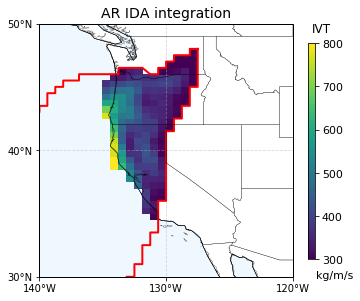

In [8]:
fig1 = plt.figure(figsize=(5,6))

ax1 = plt.subplot2grid((1,11), (0,0), colspan=10, projection=ccrs.PlateCarree())
ax1.set_xlim([-130, -115])
ax1.set_ylim([30, 50])

ax1.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', zorder=0)
ax1.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='black', linewidth=0.25,\
                                                facecolor='none', name='admin_1_states_provinces')
ax1.add_feature(countries, zorder=3)

ax1.plot(lons[AR_contour_int[:,0],AR_contour_int[:,1]], lats[AR_contour_int[:,0],AR_contour_int[:,1]],
         linewidth=2, color='red')
ARland_mask[ARland_mask==0]=np.nan
ax1.pcolormesh(lons, lats, ARland_mask, cmap='viridis', vmin=300, vmax=800)

# add gridline
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle='--', alpha=0.5)
gl.xlabels_top = False
gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,10))
gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

# add ticklabels
ax1.set_xticks(np.arange(-130,-109,10), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(30, 51, 10), crs=ccrs.PlateCarree())
ax1.set_xticklabels(('140°W','130°W','120°W','110°W','100°W','90°W','80°W'))
ax1.set_yticklabels(('30°N','40°N','50°N'))
ax1.tick_params(labelright=False, labelsize=10)

cbar_axes = fig1.add_axes([0.87, 0.25, 0.02, 0.5])
cb = matplotlib.colorbar.ColorbarBase(cbar_axes, cmap='viridis', ticks=[np.arange(0,1.01,0.2)], orientation='vertical')
cb.set_ticklabels(['300', '400', '500', '600', '700', '800'])
cbar_axes.tick_params(labelsize=11)
#cbar_axes.text(5.2, -0.02, 'kg/m/s', size=11)
cbar_axes.text(1.1, -0.09, 'kg/m/s', size=11)
cbar_axes.text(0.6, 1.05, 'IVT', size=12)

ax1.set_title('AR IDA integration', size=14)

#fig1.savefig(rootdir+'plots/fig1.png', dpi=600)
plt.show()
plt.close()
del(fig1)